In [2]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
stl_filename = r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"
mesh=trimesh.load(stl_filename)

In [2]:
#mesh.show()

In [3]:
import stltovoxel
import numpy as np
import matplotlib.pyplot as plt
input=stl_filename
output=stl_filename[:-3]+"npy"
#stltovoxel.convert_file(input, output, voxel_size=0.2)

In [4]:
voxel=np.load(stl_filename[:-3]+"npy")

In [5]:
voxel2=voxel[voxel[:,2]<30]
voxel2=voxel2[voxel2[:,2]>25]
voxel2=np.unique(voxel2,axis=0)
len(voxel),len(voxel2)

(8461377, 331189)

In [6]:
z_slice=[]
for z in np.unique(voxel2[:,2]):
    z_slice.append(voxel[voxel[:,2]==z][:,:-1])

In [7]:
def getCluster(data,label,label_number):
    center=[]
    for i in range(len(data)):
        if label[i]==label_number:
            center.append(data[i])
    return np.array(center),np.mean(center,axis=0)

def getAllClustersCenters(data,clustering):
    centers=[]
    for i in np.unique(clustering.labels_):
        _,mean_=getCluster(data,clustering.labels_,i)
        centers.append(mean_)
    return centers

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of Labels:  8


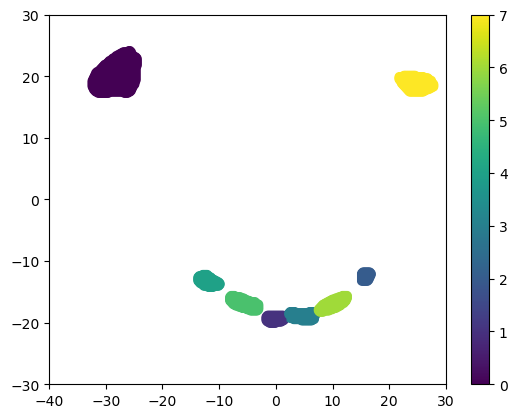

In [8]:
from sklearn.cluster import KMeans,AffinityPropagation,MeanShift,AgglomerativeClustering,SpectralClustering
X_1 = z_slice[-1]


#kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(X)
kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans_1.labels_)))
plt.scatter(X_1[:,0],X_1[:,1],c=kmeans_1.labels_)
plt.xlim([-40,30])
plt.ylim([-30,30])
plt.colorbar()

In [9]:
centers=getAllClustersCenters(X_1,kmeans_1)
from scipy.spatial.distance import pdist
X=z_slice[-2]
n_clusters=len(centers)
kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
while len(np.where(pdist(kmeans.cluster_centers_)<2)[0])==0:
    new_kmeans=kmeans
    print('yo')
    centers=list(centers)
    add=np.mean(centers,axis=0)
    centers.append([add[0],add[1]])
    centers=np.array(centers)
    n_clusters+=1
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
kmeans=new_kmeans

yo
yo


Number of Labels:  19


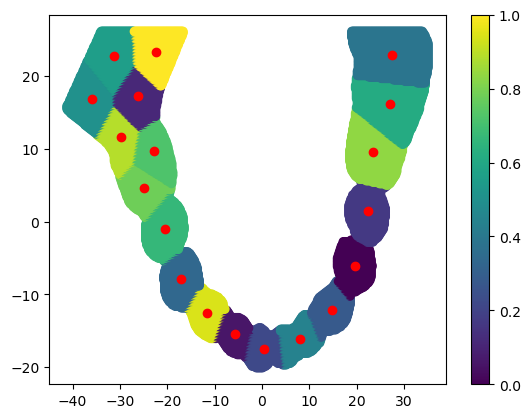

In [13]:
#kmeans = SpectralClustering(n_clusters=14).fit(X)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
plt.colorbar()

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of Labels:  8


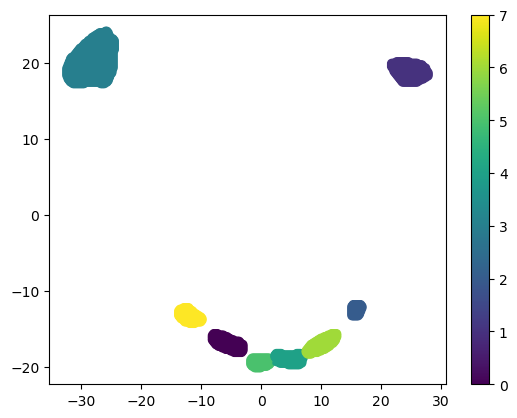

In [14]:
X=z_slice[-1]
kmeans = SpectralClustering(n_clusters=8).fit(X)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.colorbar()

In [337]:
X = z_slice[-1]
kmeans_init = SpectralClustering(n_clusters=8).fit(X)
centers=getAllClustersCenters(X,kmeans_init)
list_kmeans=[kmeans_init]
list_centers=[centers]
X_1=X
kmeans_1=kmeans
for i in range(2,25):
    X=z_slice[-i]
    n_clusters=len(list_centers[i-2])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=list_centers[i-2],n_init="auto").fit(X)
    print(n_clusters)
    kmean___=add_clusters(X,kmeans,dist_max=8)
    #kmean___.cluster_centers=joinClusters(X,kmean___,X_1,kmeans_1)
    list_centers.append(getAllClustersCenters(X,kmean___))
    list_kmeans.append(kmean___)
    X_1=X
    kmeans_1=kmeans
    # while len(np.where(pdist(kmeans.cluster_centers_)<6.2)[0])==0 and n_clusters<30:
    #     new_kmeans=kmeans
    #     centers=list(centers)
    #     ma,mi=np.max(centers),np.min(centers)
    #     add=[(ma-mi)*np.random.rand()+mi,(ma-mi)*np.random.rand()+mi]
    #     centers.append([add[0],add[1]])
    #     centers=np.array(centers)
    #     n_clusters+=1
    #     kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
    #     kmeans_temps=kmeans
    
    # kmeans=new_kmeans
    # list_centers.append(centers)
    # list_kmeans.append(kmeans)
test=[]
X_1=z_slice[-2]
kmeans_1=list_kmeans[1]
for i in range(3,25):
    X=z_slice[-i]
    kmean=list_kmeans[i]
    test.append(joinClusters(X,kmean,X_1,kmeans_1))
    X_1=X
    kmeans_1=kmeans
    

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


8
9
9
10
10
12
12
12
13
16
16
17
18
20
20
21
21
21
21
21
22
22
22


c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

In [339]:
test

[[5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,


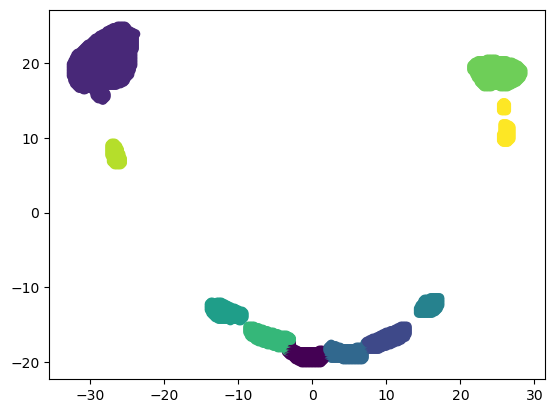

In [97]:
plt.scatter(X_1[:,0],X_1[:,1],c=kmeans_1.labels_)

In [351]:
kmeans.labels_

array([2, 2, 2, ..., 9, 9, 9])

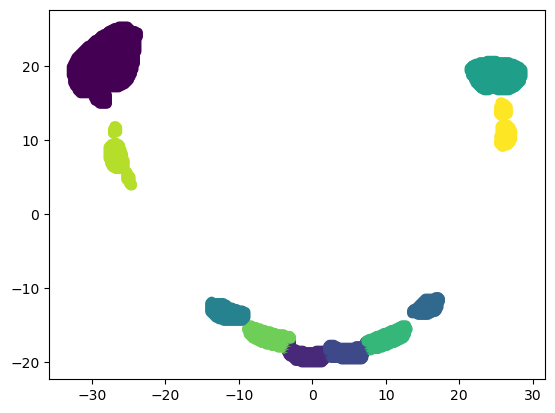

In [318]:
new_labels=joinClusters(X,kmeans,X_1,kmeans_1)
plt.scatter(X[:,0],X[:,1],c=new_labels)

Number of Labels:  21


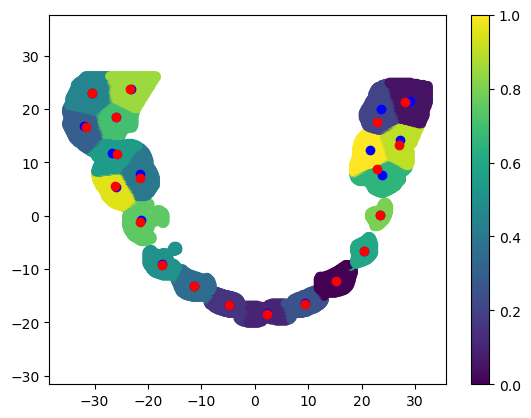

In [340]:
from sklearn.cluster import KMeans,SpectralClustering
i=15
X = z_slice[-i-1]
X_1=z_slice[-i]
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]
centers=np.array(getAllClustersCenters(z_slice[-i],kmeans_1))
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(centers[:,0],centers[:,1],c='r')
plt.axis('equal')
plt.colorbar()

Number of Labels:  10


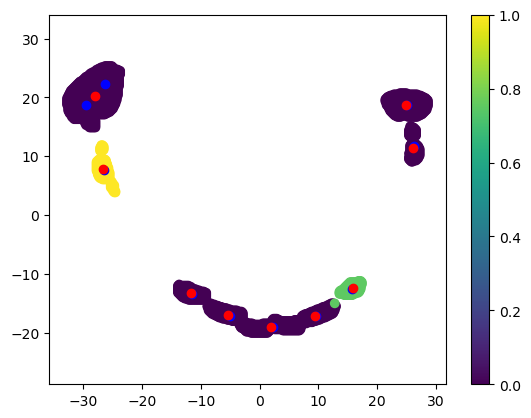

In [349]:
from sklearn.cluster import KMeans,SpectralClustering
i=3
X = z_slice[-i-1]
X_1=z_slice[-i]
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]
centers=np.array(getAllClustersCenters(z_slice[-i],kmeans_1))
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=test[0])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(centers[:,0],centers[:,1],c='r')
plt.axis('equal')
plt.colorbar()

In [350]:
len(np.unique(test[0]))

3

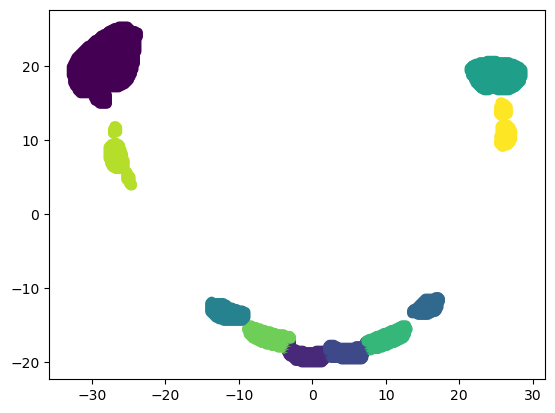

In [319]:
new_labels=joinClusters(X,kmeans,X_1,kmeans_1)
plt.scatter(X[:,0],X[:,1],c=new_labels)

In [104]:
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]

In [101]:
help(getCluster)

Help on function getCluster in module __main__:

getCluster(data, label, label_number)



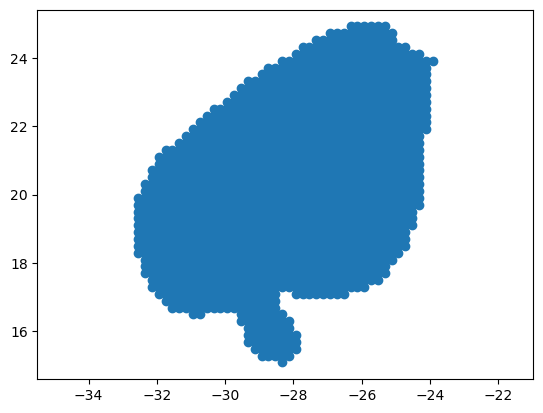

In [202]:
res_1=getCluster(X_1,kmeans_1.labels_,1)[0]
plt.axis('equal')
plt.scatter(res_1[:,0],res_1[:,1])

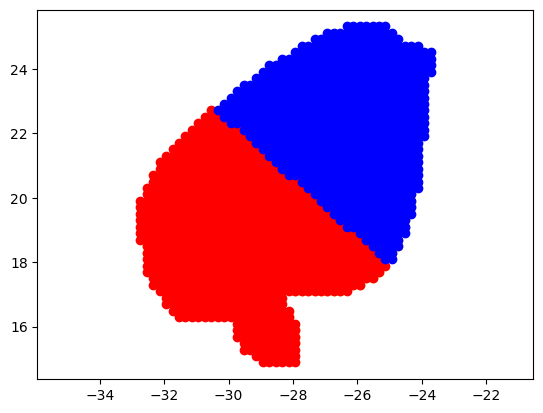

In [276]:
res=getCluster(X,kmeans.labels_,1)[0]
res_1=getCluster(X_1,kmeans_1.labels_,1)[0]
res_2=getCluster(X,kmeans.labels_,10)[0]
plt.axis('equal')

plt.scatter(res_1[:,0],res_1[:,1],c='orange')
plt.scatter(res[:,0],res[:,1],c='r')
plt.scatter(res_2[:,0],res_2[:,1],c='b')

In [214]:
distance(res,res_1)

40.94059135337218

In [329]:
from shapely import hausdorff_distance
from shapely import MultiPoint
from tqdm import tqdm
list_distance=[]
def distance(res,res_1):
    return hausdorff_distance(MultiPoint(res),MultiPoint(res_1))

def joinClusters(X,kmeans,X_1,kmeans_1):
    for i in range(len(np.unique(kmeans.labels_))):
        res=getCluster(X,kmeans.labels_,i)[0]
        distance_list=[]
        for j in range(len(np.unique(kmeans_1.labels_))):
            res_1=getCluster(X_1,kmeans_1.labels_,j)[0]
            dist=distance(res,res_1)
            if dist!=dist:
                distance_list.append(10_000)
            else:
                distance_list.append(dist)
        list_distance.append(distance_list)
    matrix_2=[np.argmin(elem) for elem in list_distance]
    new_labels=[matrix_2[label] for label in kmeans.labels_]
    return new_labels


In [305]:
new_labels=joinClusters(X,kmeans,X_1,kmeans_1)
plt.scatter(X[:,0],X[:,1],c=new_labels)

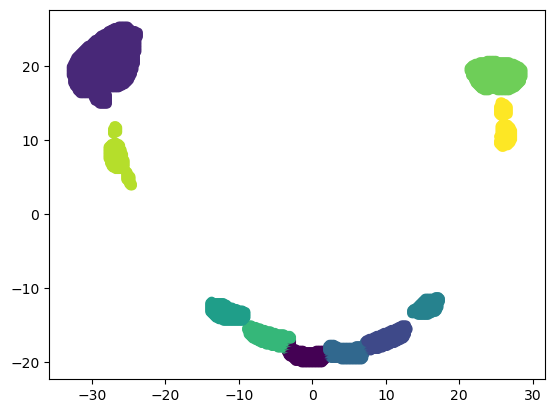

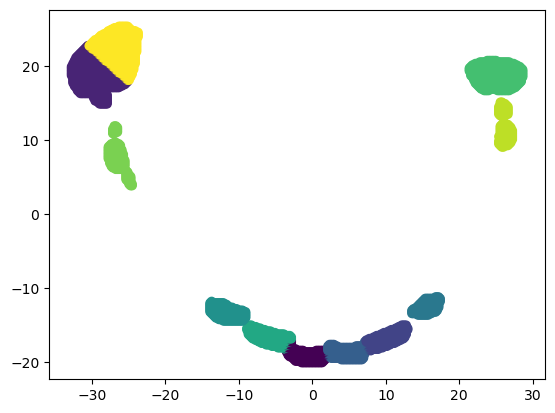

In [303]:
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)

In [282]:
matrix=np.array(list_distance)
matrix

array([[ 0.20076411, 48.26851236, 11.2926689 ,  5.62791206, 18.59097696,
        12.38126357,  6.00942982, 46.08605823, 38.02759694, 40.94059135],
       [48.59653564,  5.25064623, 55.06305632, 52.17946087, 57.47864938,
        38.59967151, 43.78726776, 54.33282285, 13.87626583, 58.59231404],
       [11.48501315, 54.76450627,  0.20076411,  5.9617776 ,  8.18460478,
        22.31167908, 16.14022931, 38.47969364, 44.81831472, 33.12301402],
       [ 5.64578828, 51.77633977,  5.84624219,  0.20076411, 13.45965471,
        17.36043116, 11.13632475, 42.32052474, 41.82214882, 37.10312222],
       [17.82271964, 56.88595123,  7.55113371, 12.73541098,  0.80193859,
        27.47813383, 22.40632003, 32.82374749, 47.03393355, 27.35967317],
       [12.19975996, 38.86115013, 21.96413161, 17.16601748, 28.27973958,
         0.28372579,  7.14285544, 49.50075762, 26.57474841, 45.64769785],
       [ 6.21934773, 43.82200583, 16.33946913, 11.33132319, 23.36083848,
         7.06581375,  0.28372579, 47.53067355

In [296]:
matrix[1]

array([48.59653564,  5.25064623, 55.06305632, 52.17946087, 57.47864938,
       38.59967151, 43.78726776, 54.33282285, 13.87626583, 58.59231404])

In [281]:
np.min(matrix),np.max(matrix),np.mean(matrix)

(0.20076411199049105, 58.59231403659854, 30.53076576944515)

In [280]:
matrix[1,1],matrix[10,1]

(5.250646227412197, 5.266743249753877)

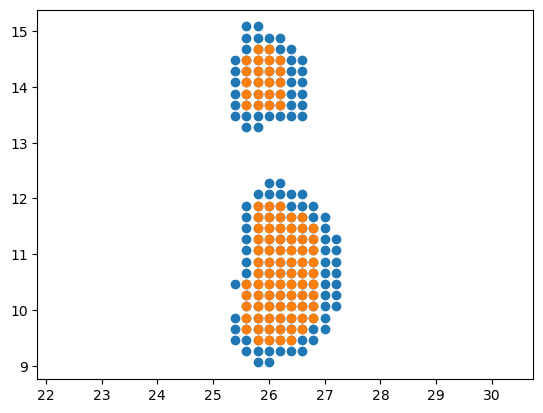

In [240]:
res=getCluster(X,kmeans.labels_,9)[0]
res_1=getCluster(X_1,kmeans_1.labels_,9)[0]
plt.axis('equal')
plt.scatter(res[:,0],res[:,1])
plt.scatter(res_1[:,0],res_1[:,1])

In [221]:
cdist(X_l,X_k,metric=distance)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [227]:
X_l[3]

array([[  4.14334601, -19.64901145],
       [  4.34383066, -19.64901145],
       [  4.5443153 , -19.64901145],
       [  4.74479995, -19.64901145],
       [  4.94528459, -19.64901145],
       [  5.14576924, -19.64901145],
       [  5.34625389, -19.64901145],
       [  5.54673853, -19.64901145],
       [  5.74722318, -19.64901145],
       [  5.94770783, -19.64901145],
       [  6.14819247, -19.64901145],
       [  6.34867712, -19.64901145],
       [  6.54916177, -19.64901145],
       [  6.74964641, -19.64901145],
       [  2.53946884, -19.44824733],
       [  2.73995349, -19.44824733],
       [  2.94043813, -19.44824733],
       [  3.14092278, -19.44824733],
       [  3.34140742, -19.44824733],
       [  3.54189207, -19.44824733],
       [  3.74237672, -19.44824733],
       [  3.94286136, -19.44824733],
       [  4.14334601, -19.44824733],
       [  4.34383066, -19.44824733],
       [  4.5443153 , -19.44824733],
       [  4.74479995, -19.44824733],
       [  4.94528459, -19.44824733],
 

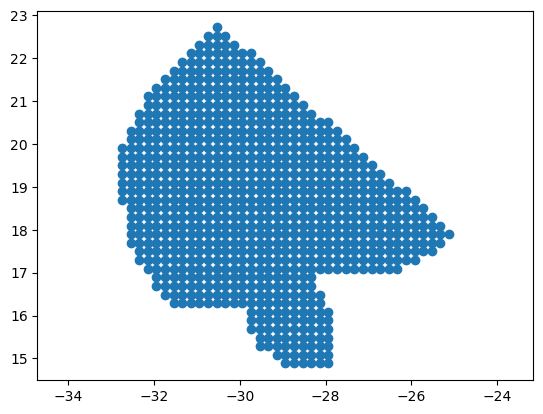

In [124]:
res=getCluster(X,kmeans.labels_,1)[0]
plt.axis('equal')
plt.scatter(res[:,0],res[:,1])

In [ ]:
from scipy.spatial.distance import cdist
dist=cdist(res,[kmean.cluster_centers_[7]],metric='cityblock')
test=res[np.where(dist>7)[0]]
res=getCluster(X,kmean.labels_,7)[0]
plt.scatter(res[:,0],res[:,1])
plt.scatter(np.mean(res,axis=0)[0],np.mean(res,axis=0)[1],c='r')
plt.scatter(test[:,0],test[:,1],c='y')

Number of Labels:  10


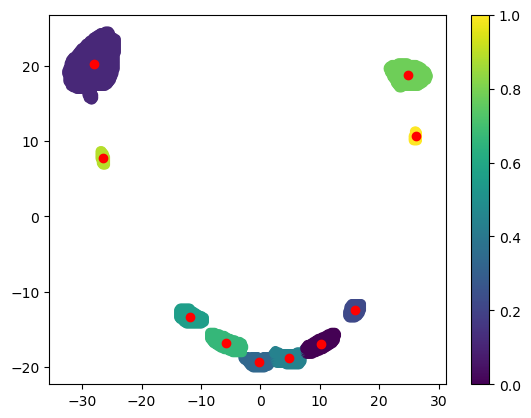

In [42]:
from scipy.spatial.distance import cdist
i=1
X = z_slice[-i-1]
#center_2=np.array(getAllClustersCenters(z_slice[-i],kmeans_1)).copy()Zz
kmean=list_kmeans[i]
center_2=list(kmeans.cluster_centers_).copy()
for i in np.unique(kmean.labels_):
    res=getCluster(X,kmean.labels_,i)[0]
    dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
    test=res[np.where(dist>10)[0]]
    if len(test>0):
        me=np.mean(test,axis=0)
        center_2.append(me)
kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
center_2=list(center_2)
for i in np.unique(kmean.labels_):
    res=getCluster(X,kmean.labels_,i)[0]
    dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
    test=res[np.where(dist>9)[0]]
    if len(test>0):
        me=np.mean(test,axis=0)
        center_2.append(me)
center_2=np.array(center_2)
kmean___ = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)

print("Number of Labels: ",len(np.unique(kmean___.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean___.labels_)
plt.scatter(kmean___.cluster_centers_[:,0],kmean___.cluster_centers_[:,1],c='r')
#plt.scatter(center_2[:,0],center_2[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  10


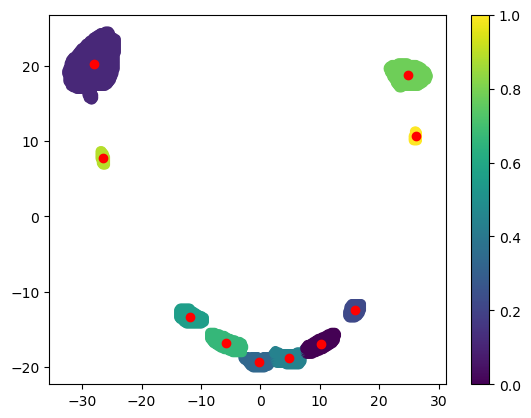

In [44]:
from scipy.spatial.distance import cdist
i=1
X = z_slice[-i-1]
#center_2=np.array(getAllClustersCenters(z_slice[-i],kmeans_1)).copy()Zz
kmean=list_kmeans[i]


def add_clusters(X,kmean,dist_max=9):
    center_2=list(kmeans.cluster_centers_).copy()
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>10)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    center_2=list(center_2)
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>dist_max)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    center_2=np.array(center_2)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    return kmean

kmean___=add_clusters(X,kmean)
print("Number of Labels: ",len(np.unique(kmean___.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean___.labels_)
plt.scatter(kmean___.cluster_centers_[:,0],kmean___.cluster_centers_[:,1],c='r')
#plt.scatter(center_2[:,0],center_2[:,1],c='b',s=5)
plt.colorbar()

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


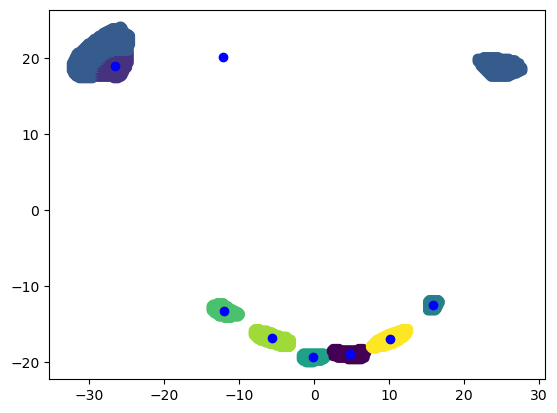

In [20]:
X = z_slice[-1]
kmeans_init = SpectralClustering(n_clusters=8).fit(X)
centers=np.array(getAllClustersCenters(z_slice[-1],kmeans_init))
plt.scatter(X[:,0],X[:,1],c=kmeans_init.labels_)
plt.scatter(centers[:,0],centers[:,1],c='b')

Number of Labels:  8


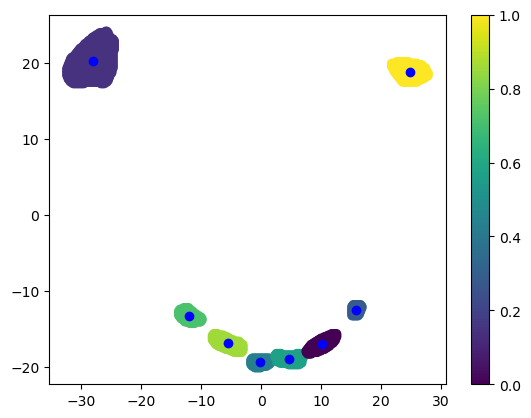

In [29]:
from sklearn.cluster import KMeans,SpectralClustering
i=0
X = z_slice[-i-1]
kmeans=list_kmeans[i]
centers=np.array(getAllClustersCenters(z_slice[-1],kmeans))
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],c='b')
plt.colorbar()

Number of Labels:  10


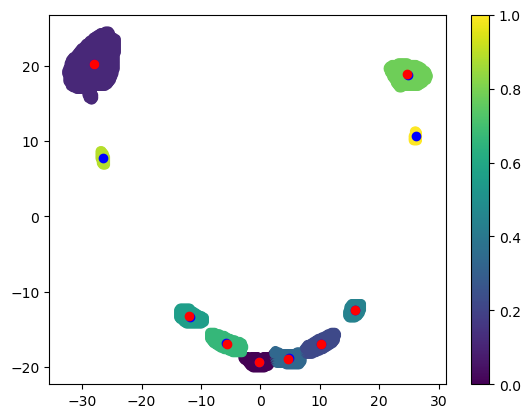

In [98]:
from sklearn.cluster import KMeans,SpectralClustering
i=1
X = z_slice[-i-1]
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]
centers=np.array(getAllClustersCenters(z_slice[-i],kmeans_1))
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(centers[:,0],centers[:,1],c='r')
plt.colorbar()

Number of Labels:  11


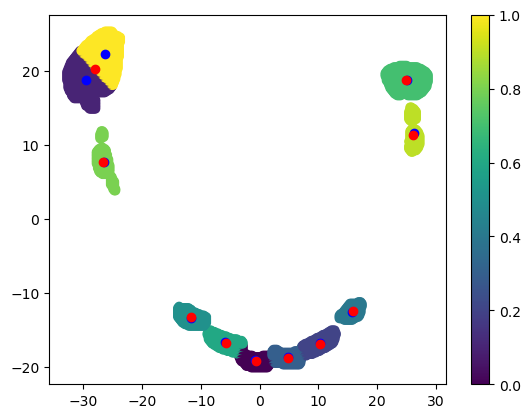

In [100]:
from sklearn.cluster import KMeans,SpectralClustering
i=3
X = z_slice[-i-1]
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]
#centers=np.array(getAllClustersCenters(z_slice[-i],kmeans_1))
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(kmeans_1.cluster_centers_[:,0],kmeans_1.cluster_centers_[:,1],c='r')
plt.colorbar()

Number of Labels:  8


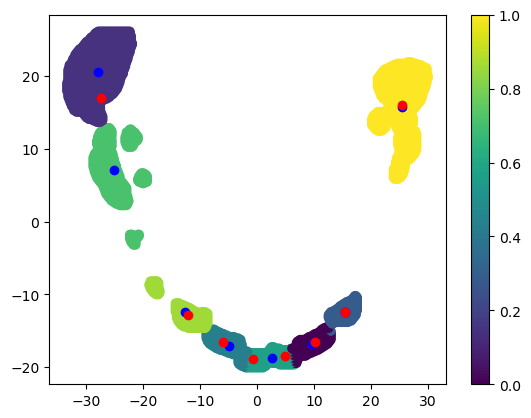

In [27]:
from sklearn.cluster import KMeans,SpectralClustering
i=7
X = z_slice[-i-1]
centers=list_centers[i]
kmeans=list_kmeans[i]
kmeans_1=list_kmeans[i-1]
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(kmeans_1.cluster_centers_[:,0],kmeans_1.cluster_centers_[:,1],c='r')
plt.colorbar()

In [16]:
from scipy.spatial.distance import squareform
def getCloseClusters(kmeans):
    test=np.array(np.where((squareform(pdist(kmeans.cluster_centers_))<6)*(squareform(pdist(kmeans.cluster_centers_))!=0)))
    res=[]
    for x in test.T:
        if x not in np.array(res) and [x[1],x[0]] not in np.array(res):
            res.append(x)
    res=np.array(res)
    return res
def joinClusters(kmeans):
    idx_close=getCloseClusters(kmeans)
    res=[]
    done=[]
    centers=kmeans.cluster_centers_
    for i in range(len(centers)):
        if i not in idx_close:
            res.append(centers[i])
        elif i not in done:
            center_one=centers[idx_close[np.where(idx_close==i)[0][0]][0]]
            center_two=centers[idx_close[np.where(idx_close==i)[0][0]][1]]
            res.append((center_one+center_two)/2)
            done.append(idx_close[np.where(idx_close==i)[0][0]][0])
            done.append(idx_close[np.where(idx_close==i)[0][0]][1])
    return np.array(res)

In [17]:
temp=joinClusters(kmeans_temps)

C:\Users\Emman\AppData\Local\Temp\ipykernel_25816\264397687.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x not in np.array(res) and [x[1],x[0]] not in np.array(res):


In [18]:
res=np.polynomial.polynomial.Polynomial.fit(kmeans_temps.cluster_centers_[:,0],kmeans_temps.cluster_centers_[:,1],deg=2,domain=[-40,40],full=True)
polynom=res[0]
res[1][0]

array([1001.56598766])

In [19]:
res=np.polynomial.polynomial.Polynomial.fit(temp[:,0],temp[:,1],deg=2,domain=[-40,40],full=True)
polynom=res[0]
res[1][0]

array([951.26741141])

In [20]:
clusters=kmeans_temps.cluster_centers_
for k in range(len(clusters)-14):
    print("#",len(clusters))
    res=[]
    for i in range(len(clusters)):
        clusters_temp=np.array([clusters[j] for j in range(len(clusters)) if i!=j ])
        test=np.polynomial.polynomial.Polynomial.fit(clusters_temp[:,0],clusters_temp[:,1],deg=2,domain=[-40,40],full=True)
        polynom=test[0]
        res.append(test[1][0])
    print("b",clusters[np.argmin(res)])
    clusters=np.array([clusters[j] for j in range(len(clusters)) if j!=np.argmin(res)])

# 18
b [-22.35070775  23.33795429]
# 17
b [-35.97602866  16.85106957]
# 16
b [-29.82265457  11.824826  ]
# 15
b [27.29647464 22.95539864]


Number of Labels:  14


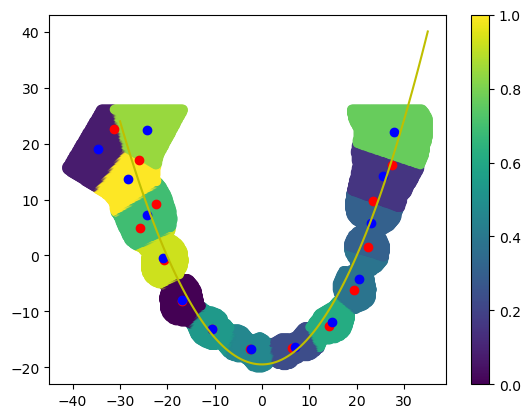

In [21]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-24]
kmeans = KMeans(n_clusters=len(clusters), random_state=0, init=clusters,n_init="auto").fit(X)
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(clusters[:,0],clusters[:,1],c='r')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
x,y=polynom.linspace(domain=[-30,35])
plt.plot(x,y,c='y')
plt.colorbar()

Number of Labels:  14


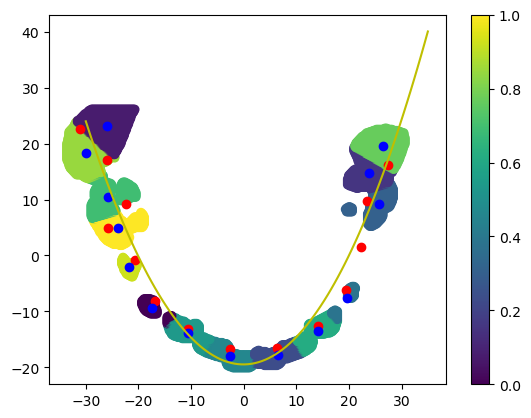

In [22]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-10]
kmeans = KMeans(n_clusters=len(clusters), random_state=0, init=clusters,n_init="auto").fit(X)
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(clusters[:,0],clusters[:,1],c='r')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
x,y=polynom.linspace(domain=[-30,35])
plt.plot(x,y,c='y')
plt.colorbar()

Number of Labels:  14


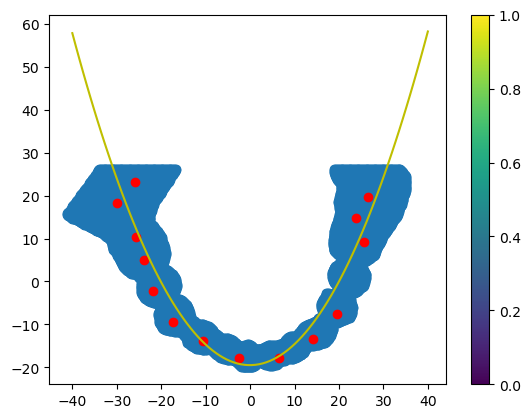

In [23]:
#kmeans = SpectralClustering(n_clusters=14).fit(X)
X=z_slice[-24]
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
x,y=polynom.linspace(domain=[-40,40])
plt.plot(x,y,c='y')
plt.colorbar()

In [24]:
X = z_slice[-1]
kmeans = SpectralClustering(n_clusters=8).fit(X)
centers=np.array(getAllClustersCenters(X,kmeans))

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of Labels:  8


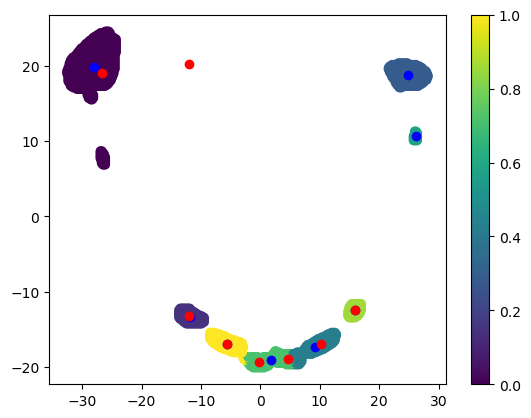

In [25]:
from sklearn.cluster import KMeans,SpectralClustering
X_1 = z_slice[-2]
kmeans_1 = KMeans(n_clusters=len(centers), random_state=0, init=centers,n_init="auto").fit(X_1)
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans_1.labels_)))
plt.scatter(X_1[:,0],X_1[:,1],c=kmeans_1.labels_)
plt.scatter(kmeans_1.cluster_centers_[:,0],kmeans_1.cluster_centers_[:,1],c='b')
plt.scatter(centers[:,0],centers[:,1],c='r')
plt.colorbar()

Number of Labels:  8


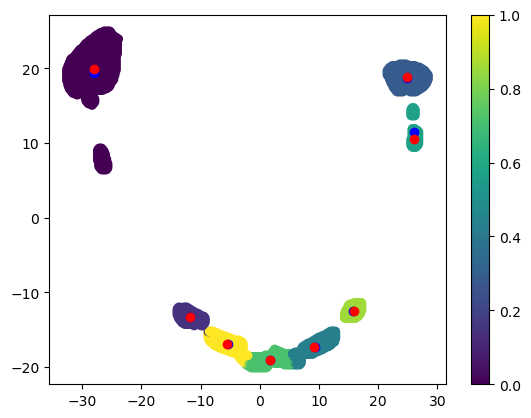

In [26]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-3]
kmeans = KMeans(n_clusters=len(centers), random_state=0, init=centers,n_init="auto").fit(X)
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
plt.scatter(kmeans_1.cluster_centers_[:,0],kmeans_1.cluster_centers_[:,1],c='r')
plt.colorbar()

Number of Labels:  14


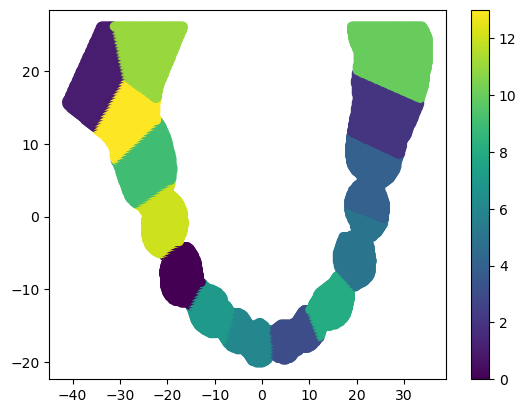

In [29]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-24]
kmeans = KMeans(n_clusters=len(clusters), random_state=0, init=clusters,n_init="auto").fit(X)
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.colorbar()

In [30]:

from scipy.spatial.distance import pdist,squareform
X=z_slice[-3]
centers=kmeans.cluster_centers_
n_clusters=len(centers)
kmeans_2 = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
while len(np.where(pdist(kmeans_2.cluster_centers_)<3)[0])==0:
    new_kmeans=kmeans_2
    print('yo')
    centers=list(centers)
    add=np.mean(centers,axis=0)
    centers.append([add[0],add[1]])
    centers=np.array(centers)
    n_clusters+=1
    kmeans_2 = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
kmeans_2=new_kmeans

In [31]:
len(kmeans.cluster_centers_)

14

Number of Labels:  14


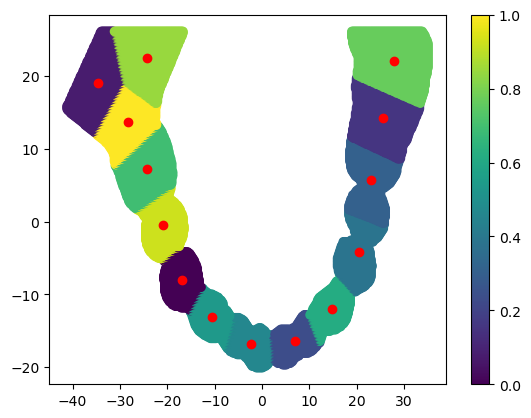

In [32]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-24]
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
plt.colorbar()

Number of Labels:  17


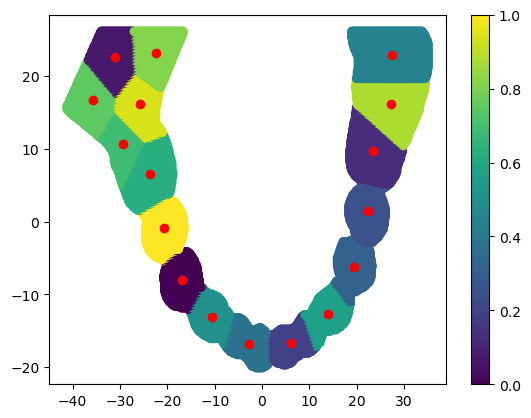

In [33]:
from sklearn.cluster import KMeans,SpectralClustering
X = z_slice[-24]
#kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
print("Number of Labels: ",len(np.unique(kmeans_2.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmeans_2.labels_)
plt.scatter(kmeans_2.cluster_centers_[:,0],kmeans_2.cluster_centers_[:,1],c='r')
plt.colorbar()

Number of Labels:  8


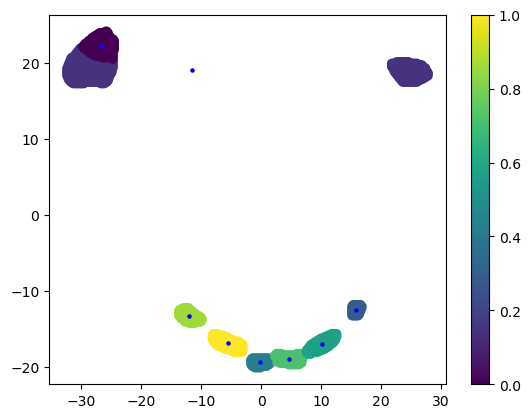

In [34]:
i=0
X = z_slice[-1]
kmean=list_kmeans[0]
center=np.array(getAllClustersCenters(X,kmean))
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
#plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

In [36]:
i=1
X = z_slice[-i-1]
center_2=center.copy()
center=list(center)
kmean=list_kmeans[i]
center.append(np.mean(test,axis=0))
center=np.array(center)
kmean = KMeans(n_clusters=len(center),random_state=0, init=center,n_init="auto").fit(X)
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Number of Labels:  9


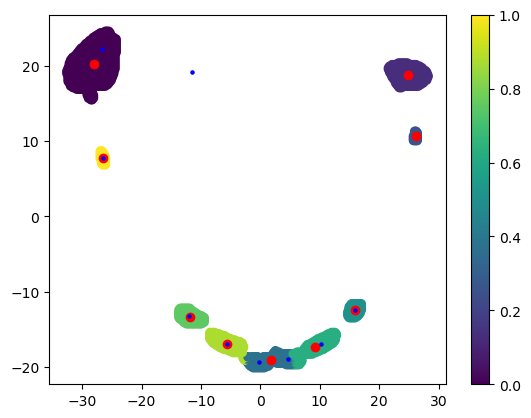

Number of Labels:  8


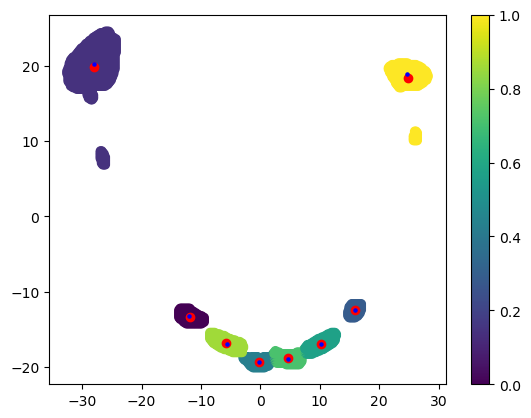

In [42]:
i=1
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


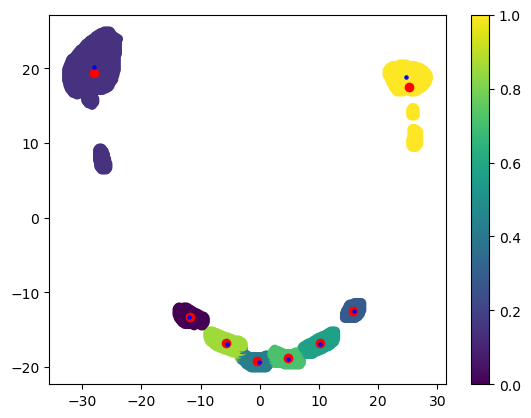

In [43]:
i=2
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


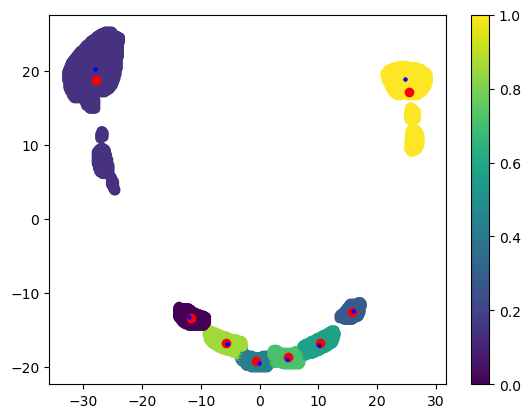

In [44]:
i=3
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


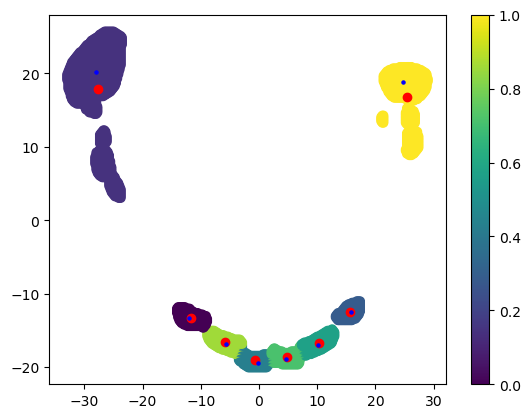

In [45]:
i=4
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


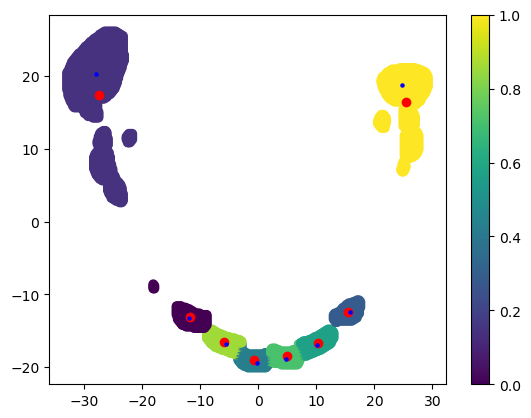

In [46]:
i=5
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


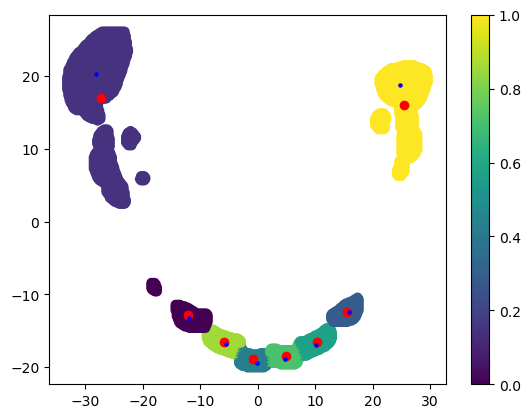

In [47]:
i=6
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  8


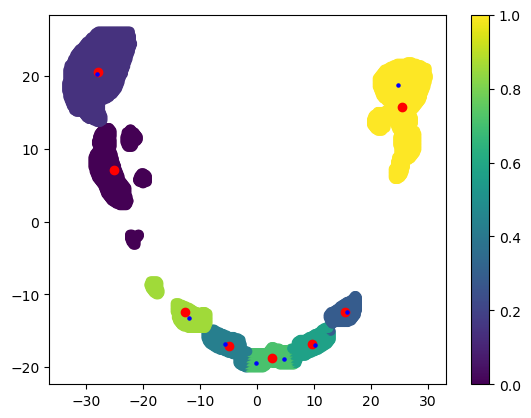

In [48]:
i=7
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  10


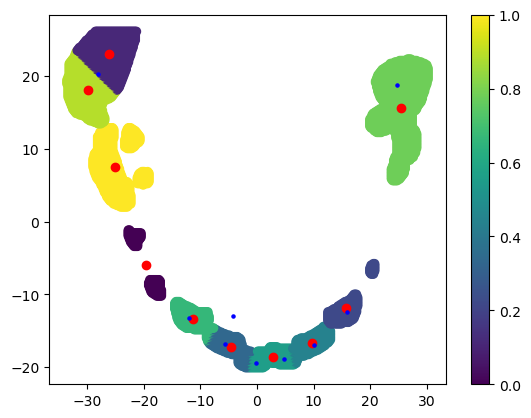

In [49]:
i=8
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  11


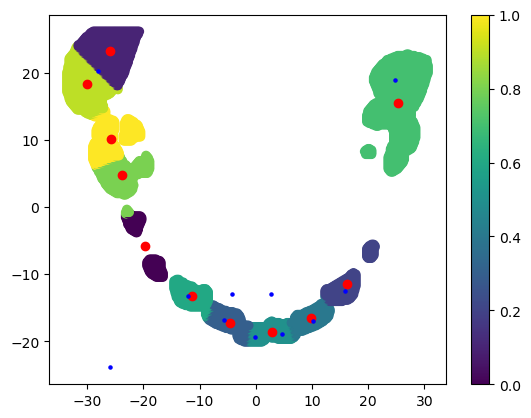

In [50]:
i=9
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  11


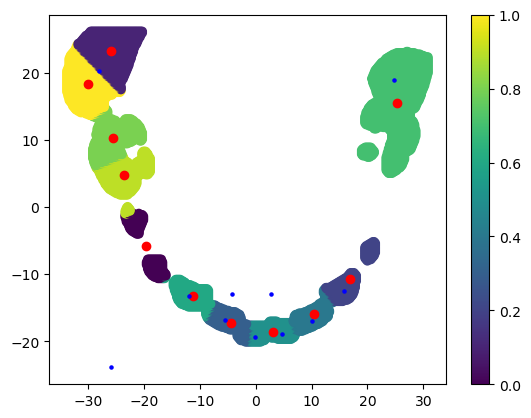

In [51]:
i=10
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  11


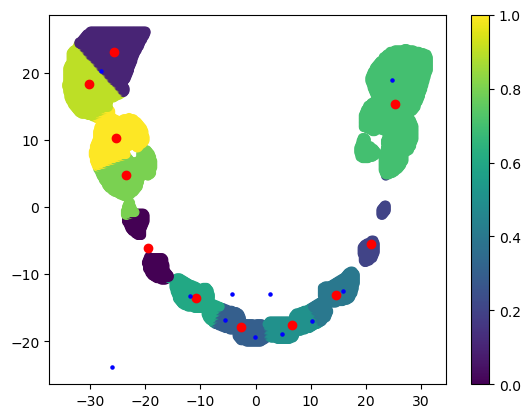

In [52]:
i=11
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  11


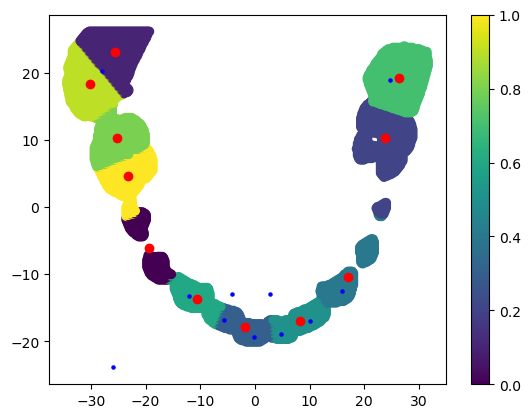

In [53]:
i=12
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  13


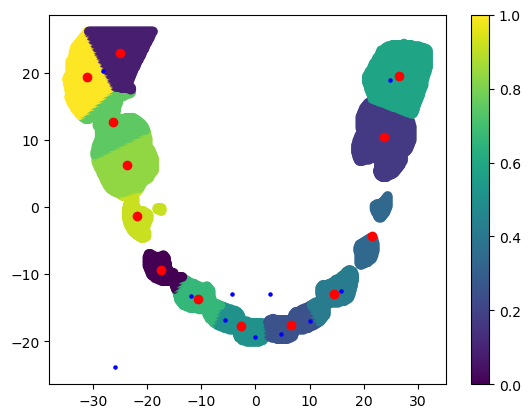

In [54]:
i=13
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  14


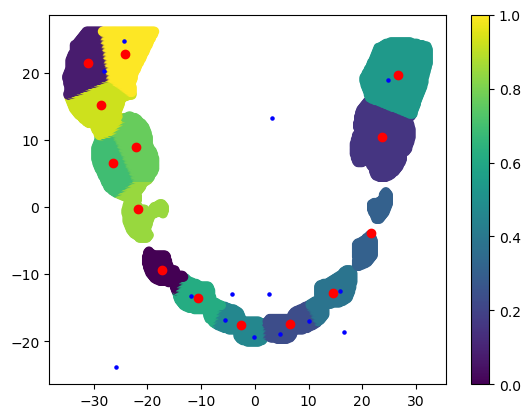

In [55]:
i=14
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  14


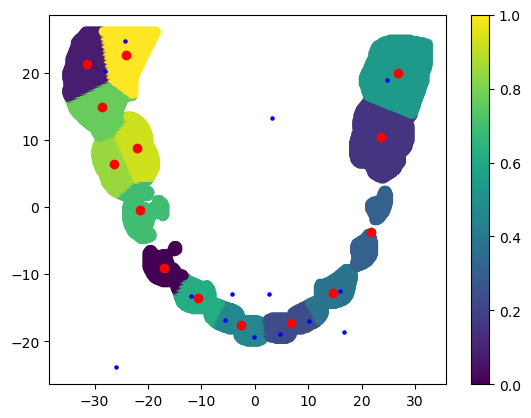

In [56]:
i=15
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  14


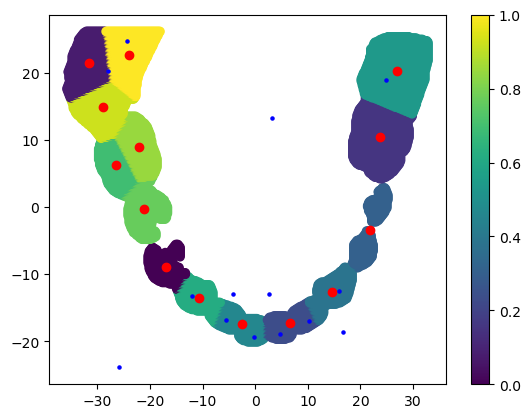

In [57]:
i=16
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()

Number of Labels:  14


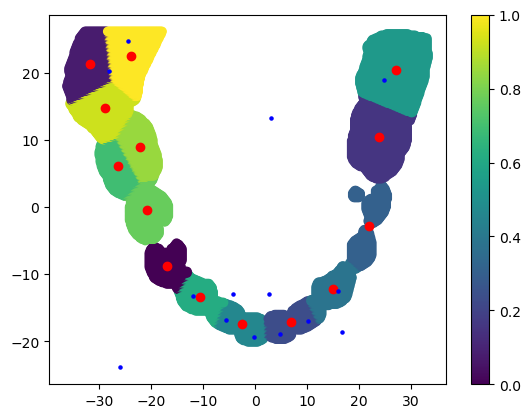

In [58]:
i=17
X = z_slice[-i-1]
center=np.array(list_centers[i-1])
kmean=list_kmeans[i]
print("Number of Labels: ",len(np.unique(kmean.labels_)))
plt.scatter(X[:,0],X[:,1],c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],c='r')
plt.scatter(center[:,0],center[:,1],c='b',s=5)
plt.colorbar()